#AI24: TEAM 31, Базовый уровень прогнозирования


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product

In [2]:
def download_stock(ticker, period="1y", interval="1d"):
    stock = yf.Ticker(ticker)
    data = stock.history(period=period, interval=interval)
    data = data[['Close']].dropna()
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    return data

In [3]:
ticker = "AAPL"
data = download_stock(ticker)

## Цены

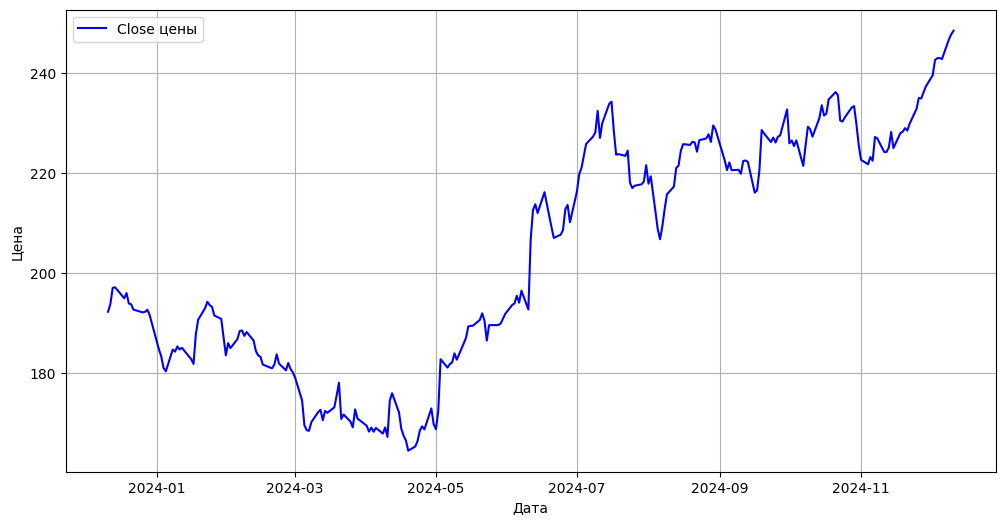

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label="Close цены", color="blue")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.grid()
plt.legend()
plt.show()

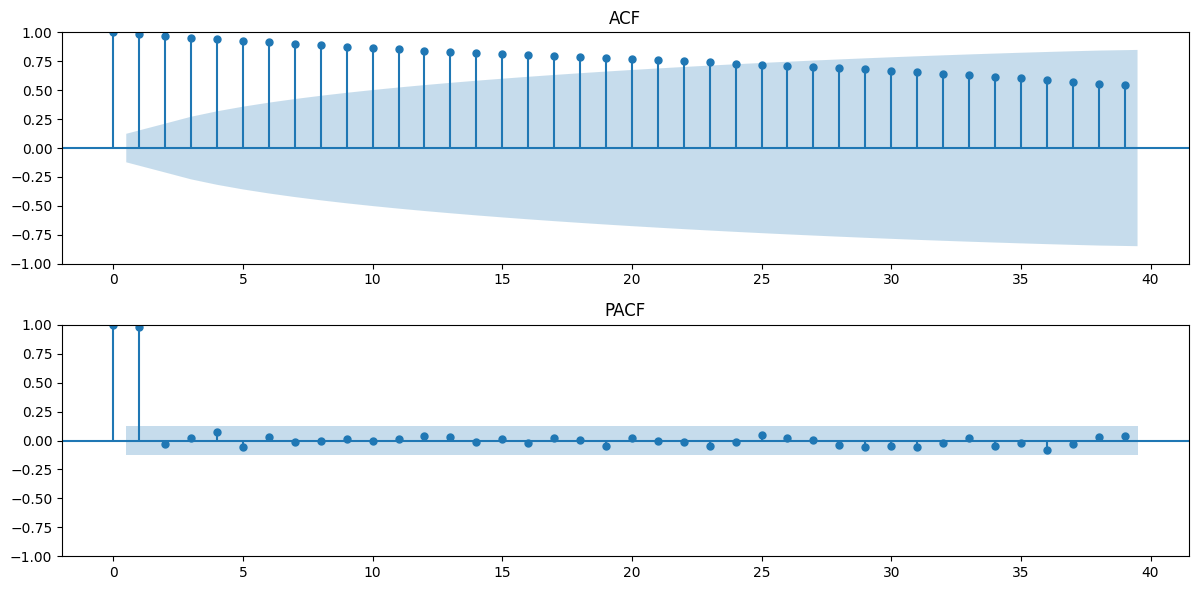

In [5]:
plt.figure(figsize=(12, 6))
plot_acf(data['Close'], lags=39, ax=plt.subplot(211), title="ACF")
plot_pacf(data['Close'], lags=39, ax=plt.subplot(212), title="PACF")
plt.tight_layout()
plt.show()

In [6]:
adf_test = adfuller(data['Close'])

In [7]:
# статистика ADF
adf_test[0]

-0.07043513024650941

In [8]:
# p-value
adf_test[1]

0.9523048422708033

In [9]:
# крит. знач
adf_test[4]

{'1%': -3.4565688966099373,
 '5%': -2.8730786194395455,
 '10%': -2.5729189953388762}

In [10]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

### ARIMA для цен с ручным подбором параметров

In [11]:
arima_model = ARIMA(train['Close'], order=(2, 1, 2))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

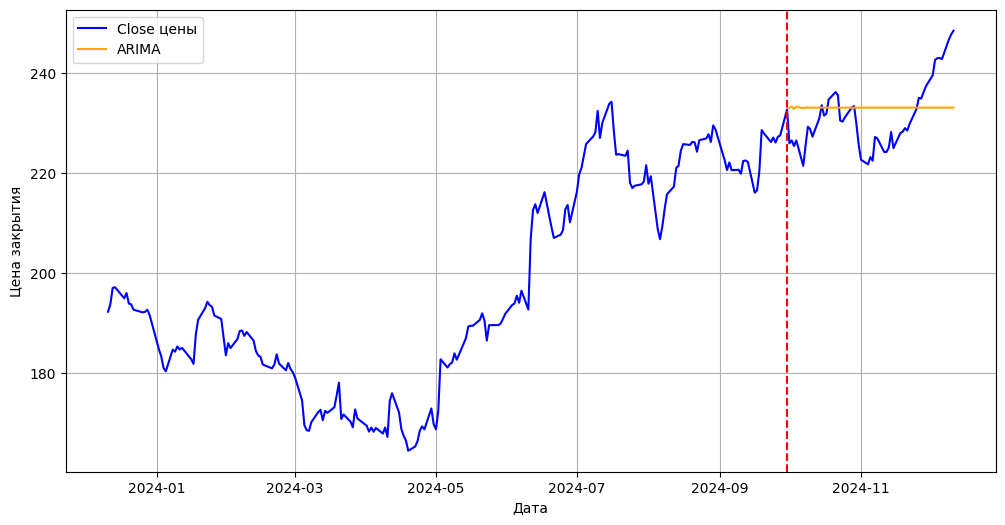

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label="Close цены", color="blue")
plt.plot(test.index, arima_forecast, label="ARIMA", linestyle="-", color="orange")
plt.axvline(x=train.index[-1], color="red", linestyle="--")
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена закрытия")
plt.grid()
plt.show()

### SARIMA с циклом подбора параметров

In [13]:
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
S = [12]
parameters = list(product(p, d, q, P, D, Q, S))
best_aic = float('inf')
best_params = None
for param in parameters:
    try:
        model = SARIMAX(train['Close'], order=(param[0], param[1], param[2]),
                        seasonal_order=(param[3], param[4], param[5], param[6]),
                        enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
    except:
        continue
sarima_model = SARIMAX(train['Close'], order=(best_params[0], best_params[1], best_params[2]),
                       seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


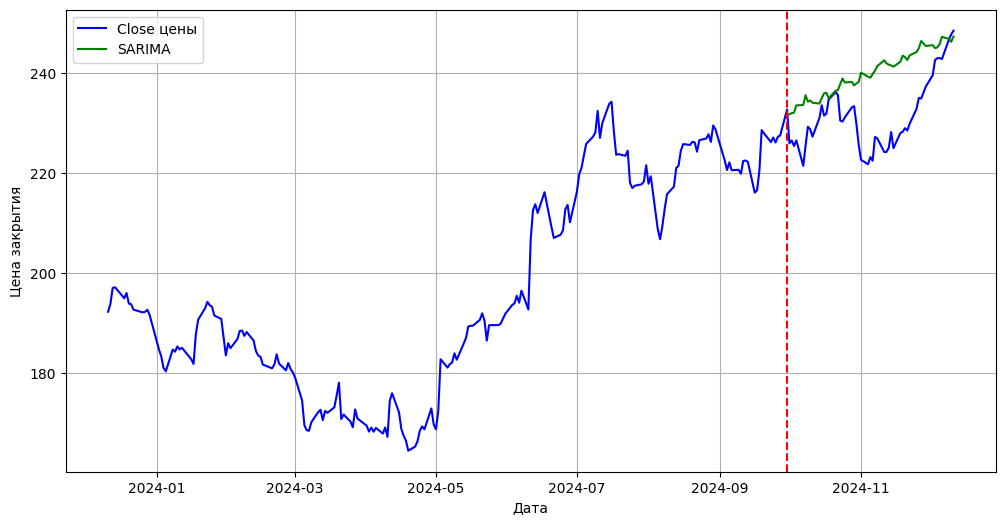

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label="Close цены", color="blue")
plt.plot(test.index, sarima_forecast, label="SARIMA", linestyle="-", color="green")
plt.axvline(x=train.index[-1], color="red", linestyle="--")
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена закрытия")
plt.grid()
plt.show()

### Экспоненциальное сглаживание

In [15]:
es_model = ExponentialSmoothing(train['Close'], trend="add", seasonal=None, initialization_method="estimated")
es_fit = es_model.fit()
es_forecast = es_fit.forecast(len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


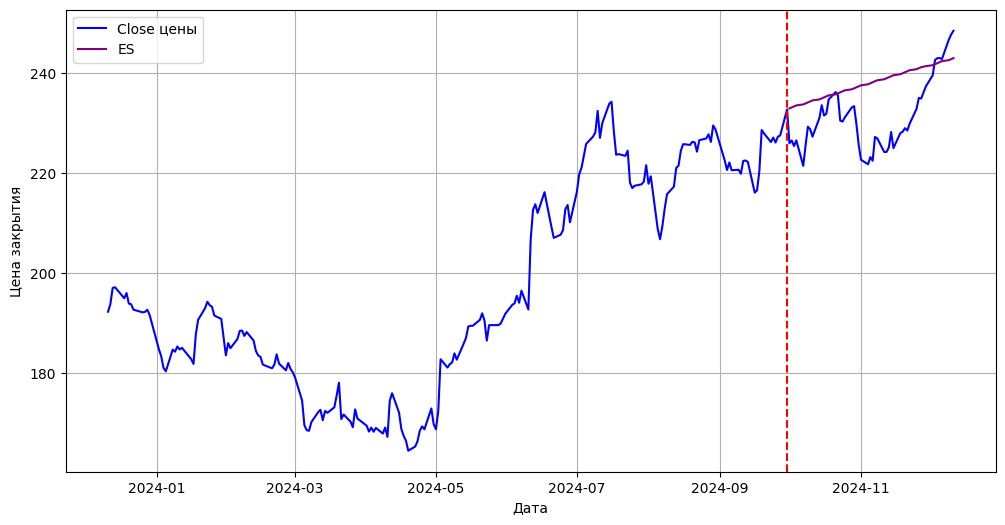

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label="Close цены", color="blue")
plt.plot(test.index, es_forecast, label="ES", linestyle="-", color="purple")
plt.axvline(x=train.index[-1], color="red", linestyle="--")
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена закрытия")
plt.grid()
plt.show()

### Linreg

In [17]:
x_train = np.arange(len(train)).reshape(-1, 1)
x_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
lr_model = LinearRegression()
lr_model.fit(x_train, train['Close'])
lr_forecast = lr_model.predict(x_test)

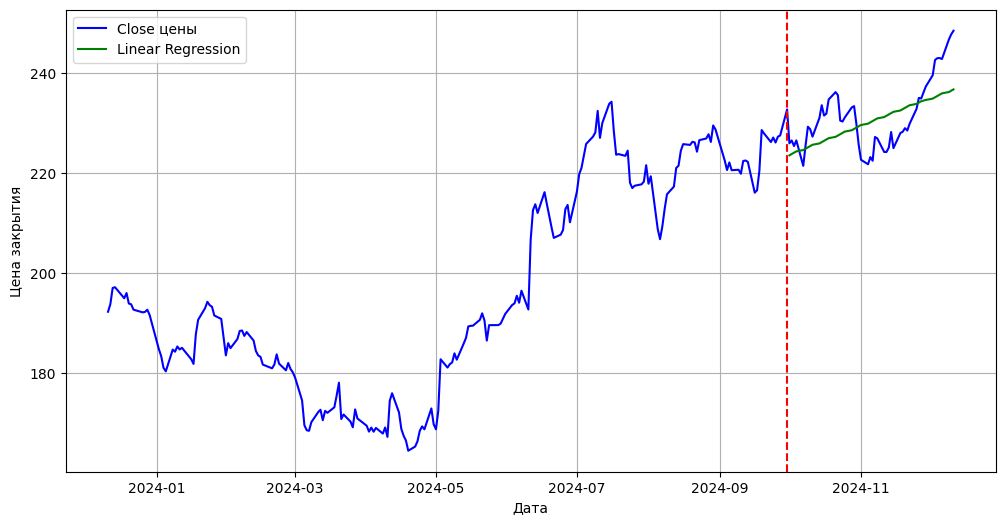

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label="Close цены", color="blue")
plt.plot(test.index, lr_forecast, label="Linear Regression", linestyle="-", color="green")
plt.axvline(x=train.index[-1], color="red", linestyle="--")
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена закрытия")
plt.grid()
plt.show()

### Общий график

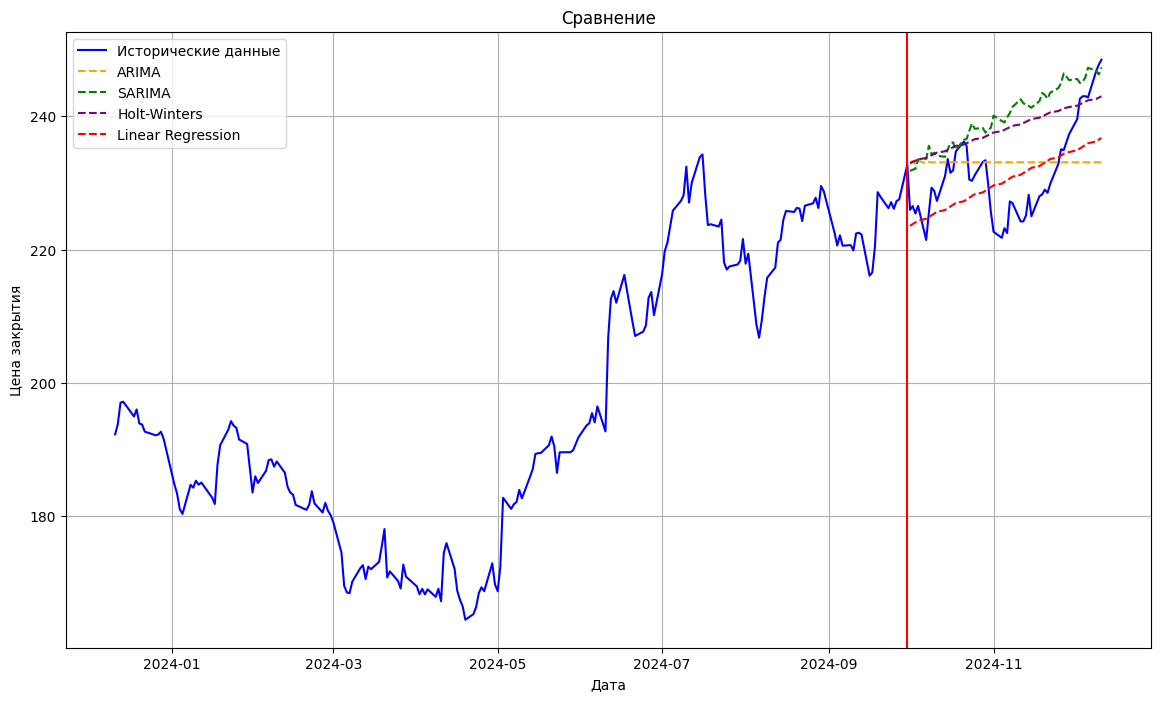

In [19]:
plt.figure(figsize=(14, 8))
plt.plot(data['Close'], label="Исторические данные", color="blue")
plt.plot(test.index, arima_forecast, label="ARIMA", linestyle="--", color="orange")
plt.plot(test.index, sarima_forecast, label="SARIMA", linestyle="--", color="green")
plt.plot(test.index, es_forecast, label="Holt-Winters", linestyle="--", color="purple")
plt.plot(test.index, lr_forecast, label="Linear Regression", linestyle="--", color="red")
plt.axvline(x=train.index[-1], color="red", linestyle="-")
plt.legend()
plt.title(f"Сравнение")
plt.xlabel("Дата")
plt.ylabel("Цена закрытия")
plt.grid()
plt.show()

In [20]:
arima_rmse = np.sqrt(mean_squared_error(test['Close'], arima_forecast))
arima_mae = mean_absolute_error(test['Close'], arima_forecast)

sarima_rmse = np.sqrt(mean_squared_error(test['Close'], sarima_forecast))
sarima_mae = mean_absolute_error(test['Close'], sarima_forecast)

es_rmse = np.sqrt(mean_squared_error(test['Close'], es_forecast))
es_mae = mean_absolute_error(test['Close'], es_forecast)

lr_rmse = np.sqrt(mean_squared_error(test['Close'], lr_forecast))
lr_mae = mean_absolute_error(test['Close'], lr_forecast)

In [21]:
metrics = pd.DataFrame({
    "Метод": ["ARIMA", "SARIMA", "ES", "Linreg"],
    "RMSE": [arima_rmse, sarima_rmse, es_rmse, lr_rmse],
    "MAE": [arima_mae, sarima_mae, es_mae, lr_mae]
})

metrics

,Метод,RMSE,MAE
0,ARIMA,7.119019,5.972298
1,SARIMA,10.346914,8.699904
2,ES,8.801839,7.426276
3,Linreg,5.703409,4.983862


## Доходности

Поскольку, исходя из темы проекта, нам интересна возможность оптимизации портфеля, то более важным показателем служит доходность - и актуальными будут не только волатильность или ковариация между доходностями, но и прогнозные значения доходности активов.



In [22]:
!pip install arch
!pip install pmdarima

In [23]:
from arch import arch_model
from pmdarima import auto_arima

In [24]:
data_2 = download_stock(ticker)

In [25]:
# логарифм разностей
data_2['Log_Returns'] = np.log(data_2['Close'] / data_2['Close'].shift(1))
data_2 = data_2.dropna()

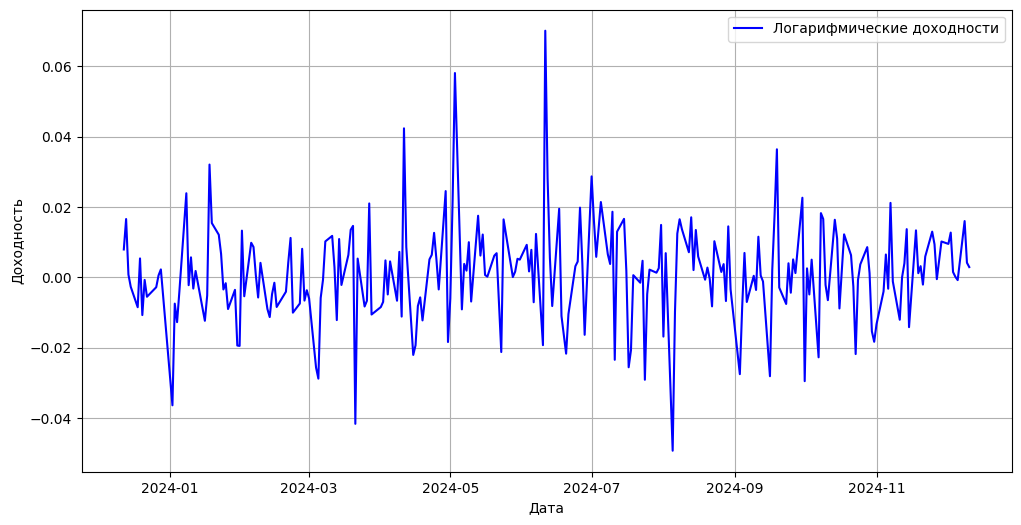

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(data_2['Log_Returns'], label="Логарифмические доходности", color="blue")
plt.xlabel("Дата")
plt.ylabel("Доходность")
plt.grid()
plt.legend()
plt.show()

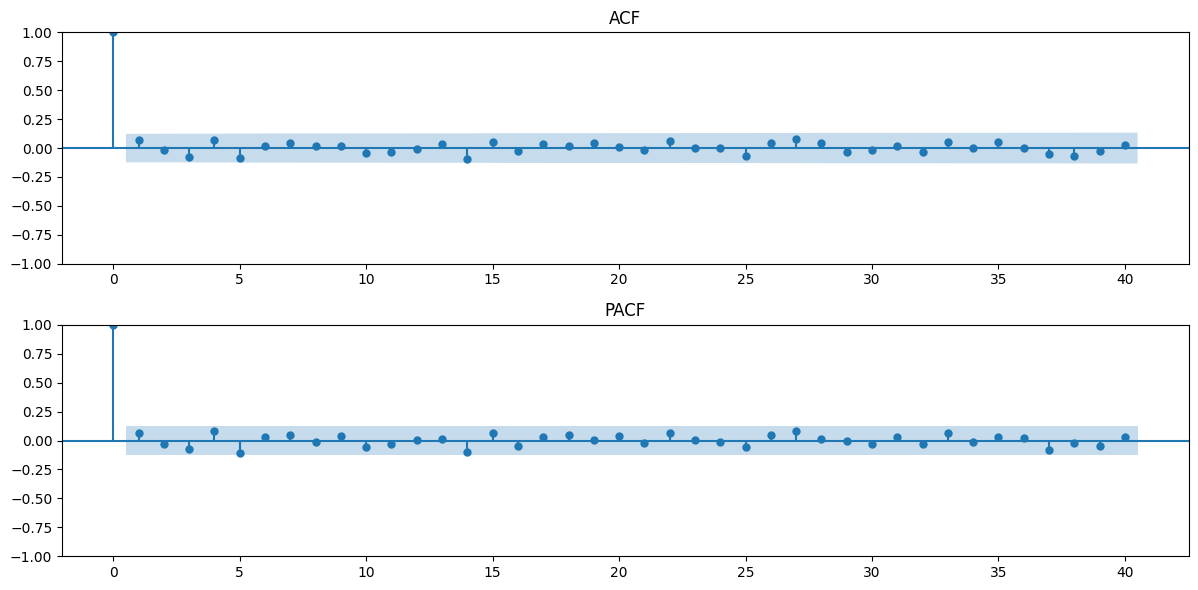

In [27]:
plt.figure(figsize=(12, 6))
plot_acf(data_2['Log_Returns'], lags=40, ax=plt.subplot(211), title="ACF")
plot_pacf(data_2['Log_Returns'], lags=40, ax=plt.subplot(212), title="PACF")
plt.tight_layout()
plt.show()

In [28]:
adf_test2 = adfuller(data_2['Log_Returns'])

In [29]:
adf_test2[0]

-14.748494645143447

In [30]:
adf_test2[1]

2.506335453071888e-27

In [31]:
adf_test2[4]

{'1%': -3.4566744514553016,
 '5%': -2.8731248767783426,
 '10%': -2.5729436702592023}

Здесь уже стационарный временной ряд

In [32]:
train_size_2 = int(len(data_2) * 0.8)
train_2, test_2 = data_2['Log_Returns'][:train_size_2], data_2['Log_Returns'][train_size_2:]


In [33]:
train_2_scaled = train_2 * 100
test_2_scaled = test_2 * 100

### GARCH

In [34]:
garch_model = arch_model(train_2_scaled, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="off")
garch_forecast = garch_fit.forecast(horizon=len(test_2_scaled)).mean.values[-len(test_2_scaled):] / 100

### EGARCH

In [35]:
egarch_model = arch_model(train_2_scaled, vol='EGarch', p=1, q=1)
egarch_fit = egarch_model.fit(disp="off")
egarch_forecast = egarch_fit.forecast(horizon=len(test_2_scaled), method="simulation").mean.values[-len(test_2_scaled):] / 100

### ARIMA c автоподбором параметров по AIС

In [36]:
arima_model_2 = auto_arima(
    train_2,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
arima_forecast_2 = arima_model_2.predict(n_periods=len(test_2))

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1115.498, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1122.349, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1121.976, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1121.999, Time=2.31 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1119.997, Time=1.62 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1121.186, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 5.263 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Экспоненциальное сглаживание

In [37]:
es_model_2 = ExponentialSmoothing(train_2, trend="add", seasonal=None, initialization_method="estimated")
es_fit_2 = es_model_2.fit()
es_forecast_2 = es_fit_2.forecast(len(test_2))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [38]:
garch_forecast = garch_fit.forecast(horizon=len(test_2_scaled), method="simulation").mean.values[-len(test_2_scaled):].flatten() / 100
egarch_forecast = egarch_fit.forecast(horizon=len(test_2_scaled), method="simulation").mean.values[-len(test_2_scaled):].flatten() / 100

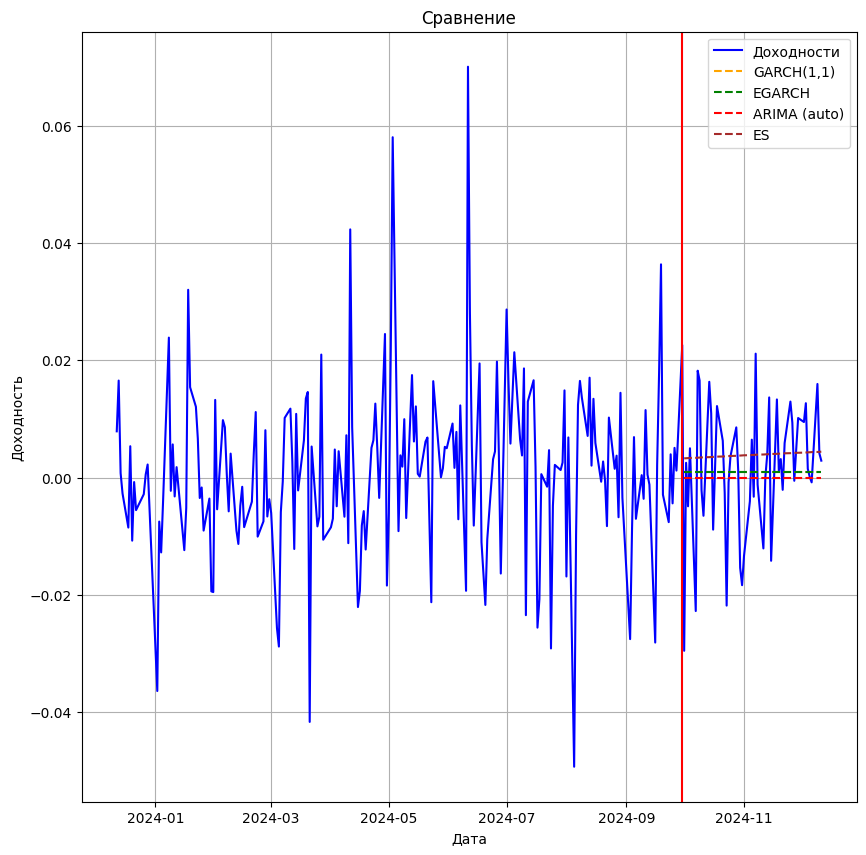

In [39]:
plt.figure(figsize=(10, 10))
plt.plot(data_2['Log_Returns'], label="Доходности", color="blue")
plt.plot(test_2.index, garch_forecast, label="GARCH(1,1)", linestyle="--", color="orange")
plt.plot(test_2.index, egarch_forecast, label="EGARCH", linestyle="--", color="green")
plt.plot(test_2.index, arima_forecast_2, label="ARIMA (auto)", linestyle="--", color="red")
plt.plot(test_2.index, es_forecast_2, label="ES", linestyle="--", color="brown")
plt.axvline(x=train_2.index[-1], color="red", linestyle="-")
plt.legend()
plt.title("Сравнение")
plt.xlabel("Дата")
plt.ylabel("Доходность")
plt.grid()
plt.show()


In [40]:
garch_rmse = np.sqrt(mean_squared_error(test_2, garch_forecast))
garch_mae = mean_absolute_error(test_2, garch_forecast)

egarch_rmse = np.sqrt(mean_squared_error(test_2, egarch_forecast))
egarch_mae = mean_absolute_error(test_2, egarch_forecast)

arima_rmse_2 = np.sqrt(mean_squared_error(test_2, arima_forecast_2))
arima_mae_2 = mean_absolute_error(test_2, arima_forecast_2)

es_rmse_2 = np.sqrt(mean_squared_error(test_2, es_forecast_2))
es_mae_2 = mean_absolute_error(test_2, es_forecast_2)

In [41]:
metrics_2 = pd.DataFrame({
    "Метод": ["GARCH(1,1)", "EGARCH", "ARIMA", "ES"],
    "RMSE": [garch_rmse, egarch_rmse, arima_rmse_2, es_rmse_2],
    "MAE": [garch_mae, egarch_mae, arima_mae_2, es_mae_2]
})

metrics_2

,Метод,RMSE,MAE
0,"GARCH(1,1)",0.011026,0.008429
1,EGARCH,0.011025,0.008423
2,ARIMA,0.011095,0.008562
3,ES,0.011238,0.008517



Несмотря на то, что изначально был очевиден факт того, что цены и доходности акций обладают высоким уровнем шума и случайности (и создание моделей с высокой предсказательной способностью затруднительно), были построены модели прогнозирования с использованием нескольких подходов, включая ARIMA, GARCH, EGARCH и экспоненциальное сглаживание. Прогнозы подтвердили сложность структуры финансовых данных, но предоставили базовую оценку, от которой можно отталкиваться, усложняя модели.
